In [1]:
import sys
sys.path.append('./code')
from importlib import reload

In [2]:
from config import row_colors, columns_to_names, row_colors_dict

2


In [3]:
import make_figure4
reload(make_figure4)
from make_figure4 import *
import pickle

goodinds = pickle.load(open('./intermediate_files/goodinds', 'rb'))
merged_clustdict = pickle.load(open('./intermediate_files/merged_clustdict', 'rb'))
merged_inds_to_subset = pickle.load(open('./intermediate_files/merged_inds_to_subset', 'rb'))
cooldict_50kb = pickle.load(open('./intermediate_files/cooldict_50kb', 'rb'))
ind_to_gene = pickle.load(open('./intermediate_files/ind_to_gene', 'rb'))
all_ind_to_region = pickle.load(open('./intermediate_files/all_ind_to_region', 'rb'))
my_treg_comp = np.load('./intermediate_files/my_treg_comp.npy')

In [4]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [5]:
from initialize import *
import cooler 

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')


(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)

# (_, _, region_to_inds_50kb, all_region_to_ind_50kb, 
#     inds_to_region_50kb, all_ind_to_region_50kb,
#     chrom_to_start_50kb, chrom_to_end_50kb) = initialize_helper_vars(treg_50kb)

In [6]:
gene_to_ind = pickle.load(open('gene_to_ind.p', 'rb'))

In [7]:
all_intra_treg_metadomains = np.load('intermediate_files/all_intra_treg_metadomains.npy')
all_intra_tcon_metadomains = np.load('intermediate_files/all_intra_tcon_metadomains.npy')
all_intra_metadomains = (all_intra_treg_metadomains + all_intra_tcon_metadomains > 0)

rows = []
for i, j in zip(*np.where(np.triu(all_intra_metadomains))):
    row = all_ind_to_region[i] + all_ind_to_region[j]
    rows.append(row)
df = pd.DataFrame(rows)
df.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
df['cluster'] = 'shared'

In [8]:
df1 = df[['chrom1', 'start1', 'end1', 'cluster']].copy()
df2 = df[['chrom2', 'start2', 'end2', 'cluster']].copy()
df1.columns = ['chrom', 'start', 'end', 'cluster']
df2.columns = ['chrom', 'start', 'end', 'cluster']

df1.loc[:, 'ind'] = (df1['start'] // 250_000 + df1['chrom'].apply(lambda x: chrom_to_start[x]))
df2.loc[:, 'ind'] = (df2['start'] // 250_000 + df2['chrom'].apply(lambda x: chrom_to_start[x]))

In [9]:
%autoreload 2
from collections import defaultdict
from make_figure4 import *
import itertools
from hub_pileup import *
from compute_differential_hic_hub import *

our_treg_25kb = cooler.Cooler('./Treg_all.mcool::/resolutions/25000')
our_tcon_25kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/25000')

metadomain_pileup_cooldict = {
    'Our_Treg' : our_treg_25kb,
    'Our_Tcon' : our_tcon_25kb,
}
intra_mat_dict = defaultdict(list)
intra_metadata = []
padding_size = 30

intra_all_mat_dict, intra_all_metadata = pileup_direct_bin_pairs(df1, df2, metadomain_pileup_cooldict, 
                                                              {x : y for x, y in chrom_to_start.items()}, 
                                                              None, 
                                                              None, 
                                                              skip_metadomains=True,
                                                              padding_size=padding_size, 
                                                              fetch_oe=True,
                                                              resolution_out = 25_000,
                                                              intra=True,
                                                              inter=False
                                                                )

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 4


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 2


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 10


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 17


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 15


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 9


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 11


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 19


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with X


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 14


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 6


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 16


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 18


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 12


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 8


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 1


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 13


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 5


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 3


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 7


In [10]:
deseq_effect_mat = np.load('./intermediate_files/deseq_effect_mat.npy')
deseq_pval_mat = np.load('./intermediate_files/deseq_pval_mat.npy')

In [11]:
ind1, ind2 = intra_all_metadata['ind1'], intra_all_metadata['ind2']
intra_all_metadata['cluster1'] = (deseq_pval_mat[ind1, ind2] < .05) * np.sign(deseq_effect_mat[ind1, ind2])
intra_all_metadata['cluster2'] = (deseq_pval_mat[ind1, ind2] < .05) * np.sign(deseq_effect_mat[ind1, ind2])
intra_all_metadata['cluster1'] = intra_all_metadata['cluster1'].fillna(0)
intra_all_metadata['cluster2'] = intra_all_metadata['cluster2'].fillna(0)

In [12]:
import matplotlib as mpl

columns_to_names = {
    1 : 'Treg Up',
    -1 : 'Treg Down',
    0 : 'NS',
}

In [13]:
plt.rcParams['text.usetex'] = False

#### Figure S7E

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:75: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:76: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hub_pileup.py:401: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([-cutoff, "Anchor1", cutoff])


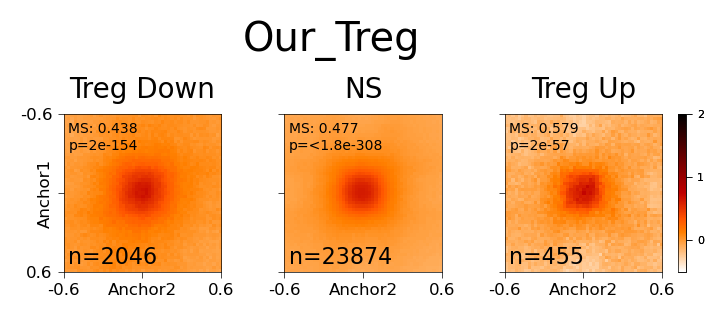

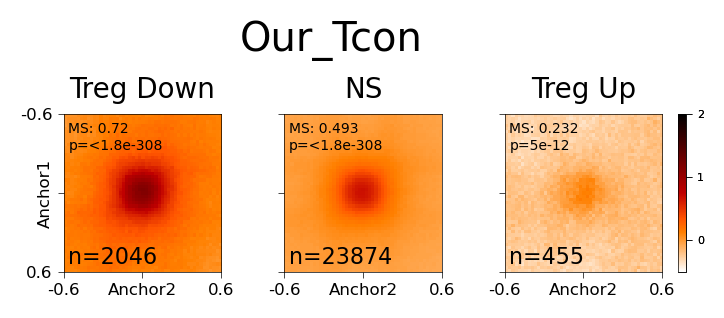

In [14]:
%autoreload 2
from hub_pileup import *

newline = '\n'
all_results_dicts = {}
for key in intra_all_mat_dict:
    (fig_within_cluster), results = plot_cluster_pileups_from_result(key, intra_all_mat_dict, intra_all_metadata,
                                     sorted(intra_all_metadata['cluster1'].unique()),
                                     res = 25_000,
                                     vmax = 2,
                                     vmin = -.5,
                                     columns_to_names = columns_to_names,
                                     row_colors_dict = row_colors_dict,
                                     center = 5, cross_plot = False, s2 = -1,
                                                                     s1 = 6,
                                                                     xspace=1.4,
                                    )
    fig_within_cluster = fig_within_cluster[0]
    fig_within_cluster.suptitle(f"{key}", y=4, x=1.7, ha='center')
    fig_within_cluster.savefig(f'./plots/paper/s11/{key}_within_cluster.pdf', bbox_inches='tight')
    all_results_dicts[key] = results

#### Intrachromosomal by p-value (Figure 2B)

In [15]:
df = pd.read_csv('intermediate_files/metadomain_with_pval.csv', index_col=0)
df.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'pval']
df['cluster'] = df['pval']

In [16]:
df1 = df[['chrom1', 'start1', 'end1', 'cluster']].copy()
df2 = df[['chrom2', 'start2', 'end2', 'cluster']].copy()
df1.columns = ['chrom', 'start', 'end', 'cluster']
df2.columns = ['chrom', 'start', 'end', 'cluster']

df1.loc[:, 'ind'] = (df1['start'] // 250_000 + df1['chrom'].apply(lambda x: chrom_to_start[x]))
df2.loc[:, 'ind'] = (df2['start'] // 250_000 + df2['chrom'].apply(lambda x: chrom_to_start[x]))

In [17]:
%autoreload 2
from collections import defaultdict
from make_figure4 import *
import itertools
from hub_pileup import *
from compute_differential_hic_hub import *

our_treg_25kb = cooler.Cooler('./Treg_all.mcool::/resolutions/25000')
our_tcon_25kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/25000')

metadomain_pileup_cooldict = {
    'Our_Treg' : our_treg_25kb,
    'Our_Tcon' : our_tcon_25kb,
}
intra_mat_dict = defaultdict(list)
intra_metadata = []
padding_size = 30

intra_all_mat_dict, intra_all_metadata = pileup_direct_bin_pairs(df1, df2, metadomain_pileup_cooldict, 
                                                              {x : y for x, y in chrom_to_start.items()}, 
                                                              None, 
                                                              None, 
                                                              skip_metadomains=True,
                                                              padding_size=padding_size, 
                                                              fetch_oe=True,
                                                              resolution_out = 25_000,
                                                              intra=True,
                                                              inter=False
                                                                )

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 4


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 2


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 10


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 17


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 15


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 9


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 11


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 19


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with X


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 14


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 6


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 16


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 18


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 12


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 8


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 1


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 13


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 5


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 3


/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with 7


In [18]:
%autoreload 2
from hub_pileup import *
import matplotlib as mpl

og_pval = intra_all_metadata['cluster1'].copy()
cutoffs = [20, 22, 25, 30, 40, 80, np.inf]
clusters = pd.cut(og_pval, cutoffs, labels=False)
intra_all_metadata['og_pval'] = og_pval

intra_all_metadata['cluster1'] = clusters
intra_all_metadata['cluster2'] = clusters


In [19]:
import matplotlib.pyplot as plt

# Set the mathtext default to 'regular' globally
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams['text.usetex'] = False

columns_to_names = {}
cutoffs = [1, 2, 3, 4, 5, 6, 7, 8] 
for c, x in enumerate(cutoffs[:-1]):
    y = cutoffs[c + 1]
    if c == len(cutoffs) - 2:
        columns_to_names[c] = f'$p < 10^{{-{x}}}$'  # Correctly formatted
    else:
        columns_to_names[c] = f'$10^{{-{y}}} < p < 10^{{-{x}}}$'  # Corrected typo here

### Figure 2B

Our_Treg


/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:75: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:76: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hub_pileup.py:401: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([-cutoff, "Anchor1", cutoff])


Our_Tcon


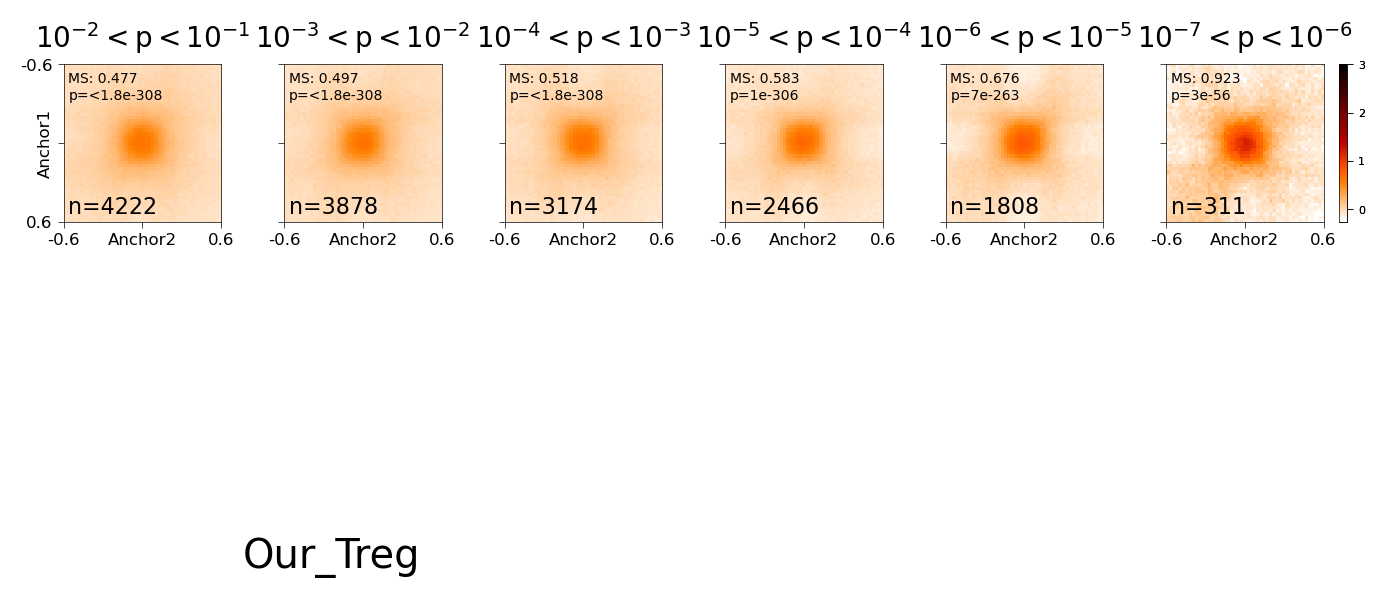

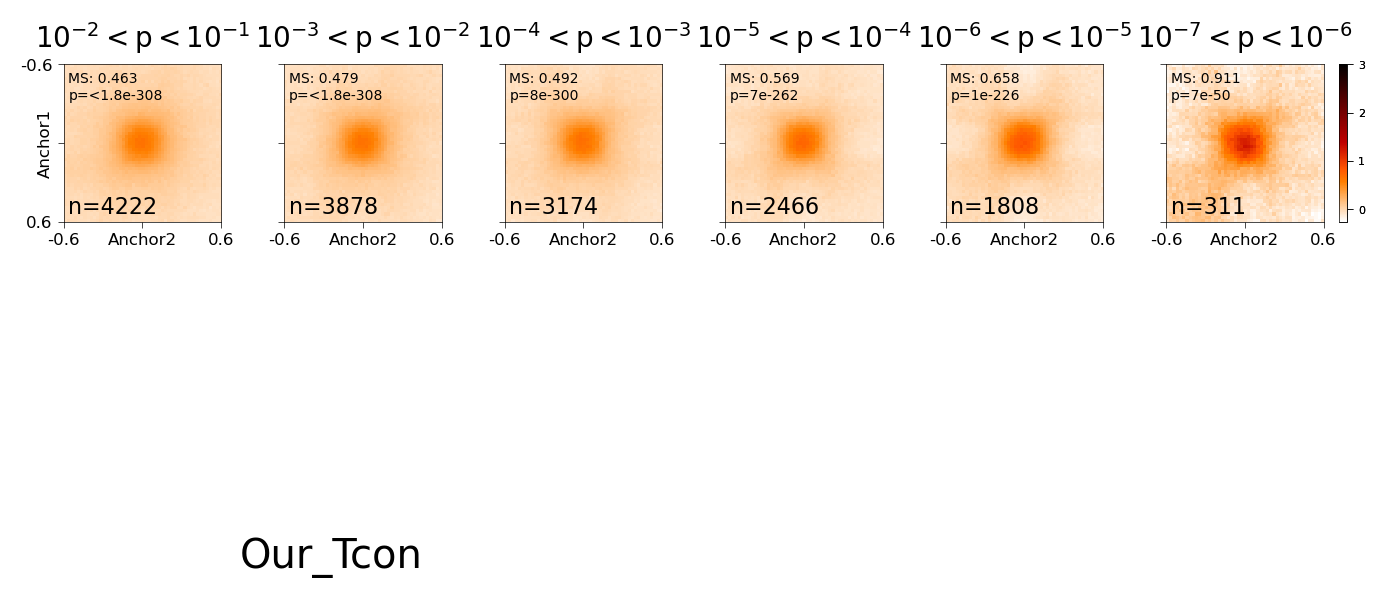

In [20]:
newline = '\n'
all_results_dicts = {}
for key in intra_all_mat_dict:
    print(key)
    (fig_within_cluster), results = plot_cluster_pileups_from_result(key, intra_all_mat_dict, intra_all_metadata,
                                     sorted(intra_all_metadata['cluster1'].unique()),
                                     res = 25_000,
                                     vmax = 3,
                                     vmin = -.25,
                                     columns_to_names = columns_to_names,
                                     row_colors_dict = {x: 'black' for x in columns_to_names.values()},
                                     center = 5, cross_plot = False, s2 = -1,
                                                                     s1 = 6,
                                                                     xspace=1.4,
                                    )
    fig_within_cluster = fig_within_cluster[0]
    fig_within_cluster.suptitle(f"{key}", y=4, x=1.7, ha='center')
    fig_within_cluster.savefig(f'./plots/paper/{key}_within_cluster.pdf', bbox_inches='tight')
    all_results_dicts[key] = results

### Interchromosomal (Figure S10B)

In [21]:
df = pd.read_csv('./intermediate_files/inter_metadomain_with_pval.csv', index_col=0)
df.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'pval']
df['cluster'] = df['pval']


df1 = df[['chrom1', 'start1', 'end1', 'cluster']].copy()
df2 = df[['chrom2', 'start2', 'end2', 'cluster']].copy()
df1.columns = ['chrom', 'start', 'end', 'cluster']
df2.columns = ['chrom', 'start', 'end', 'cluster']

df1.loc[:, 'ind'] = (df1['start'] // 250_000 + df1['chrom'].apply(lambda x: chrom_to_start[x]))
df2.loc[:, 'ind'] = (df2['start'] // 250_000 + df2['chrom'].apply(lambda x: chrom_to_start[x]))

df1['chrom'] = 'chr' + df1['chrom']
df2['chrom'] = 'chr' + df2['chrom']

In [22]:
bad = (df1['chrom']=='chrX') | (df2['chrom']=='chrX')

df1 = df1[~bad]
df2 = df2[~bad]

In [23]:
%autoreload 2
from hub_pileup import *
from compute_differential_hic_hub import *
from collections import defaultdict
from make_figure4 import *
import itertools

cooldict = {
    'Tn.1' : cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_cools/OGYuri.Tn.1.cool::/resolutions/25000'),
    'Tn.2' : cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_cools/OGYuri.Tn.2.cool::/resolutions/25000'),
    'Tn.3' : cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_cools/OGYuri.Tn.3.cool::/resolutions/25000'),
    'Treg.1' : cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_cools/OGYuri.Treg.1.cool::/resolutions/25000'),
    'Treg.2' : cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_cools/OGYuri.Treg.2.cool::/resolutions/25000'),
    'Treg.3' : cooler.Cooler('/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/zoomified_cools/OGYuri.Treg.3.cool::/resolutions/25000'),
}

inter_mat_dict = defaultdict(list)
inter_metadata = []
padding_size = 30



inter_all_mat_dict, inter_all_metadata = pileup_direct_bin_pairs(df1, df2, cooldict, 
                                                              {'chr' + x : y for x, y in chrom_to_start.items()}, 
                                                              None, 
                                                              None, 
                                                              skip_metadomains = True,
                                                              padding_size=padding_size, 
                                                              fetch_oe=True,
                                                              resolution_out = 25_000,
                                                              intra=False,
                                                              inter=True
                                                                )

Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr7
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr14
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr1
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with chr16
Done with ch

In [24]:
og_pval = inter_all_metadata['cluster1'].copy()
cutoffs = [5, 5.5, 6, 7,  np.inf]
clusters = pd.cut(og_pval, cutoffs, labels=False)

inter_all_metadata2 = inter_all_metadata.copy()
inter_all_metadata2['og_pval'] = og_pval
inter_all_metadata2['cluster1'] = clusters
inter_all_metadata2['cluster2'] = clusters

In [25]:
import matplotlib as mpl

# Set the mathtext default to regular
mpl.rcParams["mathtext.default"] = "regular"

columns_to_names = {}
for c, x in enumerate(cutoffs[:-1]):
    y = cutoffs[c + 1]
    if c == len(cutoffs) - 2:
        columns_to_names[c] = f'$p < 10^{{-{x}}}$'
    else:
        columns_to_names[c] = f'$10^{{-{y}}} < p < 10^{{-{x}}}$'


### Figure S10B

/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:75: RuntimeWarning: Mean of empty slice
  v_middle = np.nanmean(ms_treg[:, inside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/compute_differential_hic_hub.py:76: RuntimeWarning: Mean of empty slice
  v_outside = np.nanmean(ms_treg[:, outside_filt], axis=1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hub_pileup.py:401: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels([-cutoff, "Anchor1", cutoff])


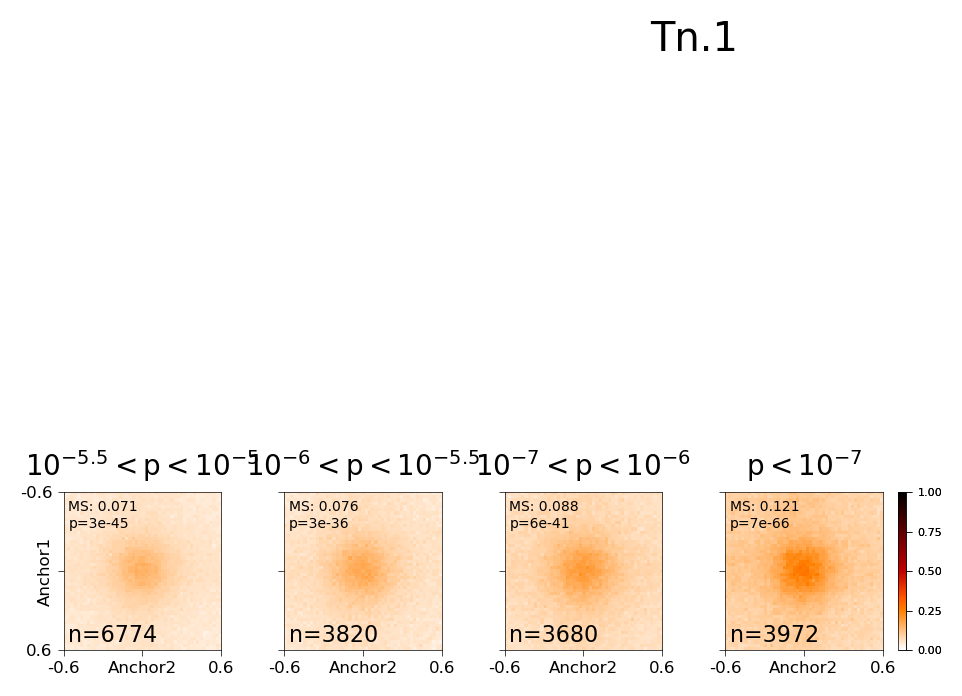

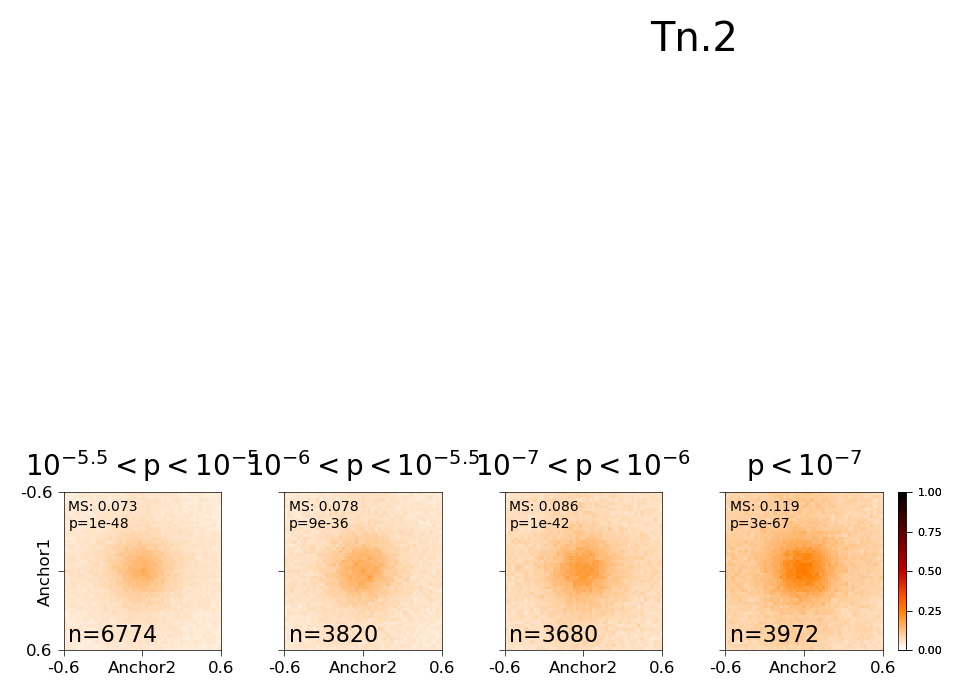

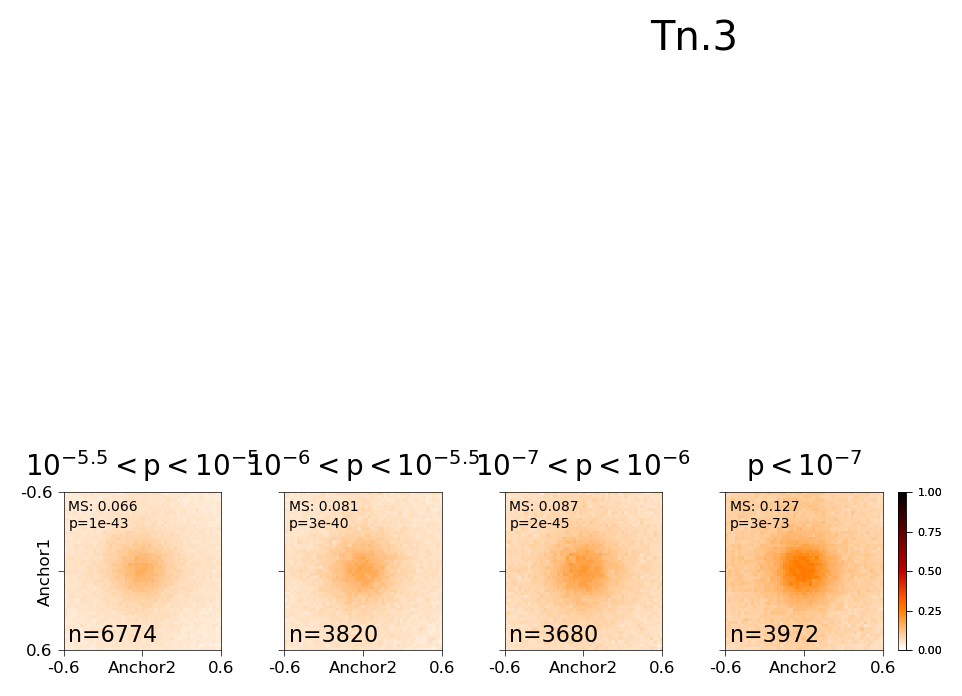

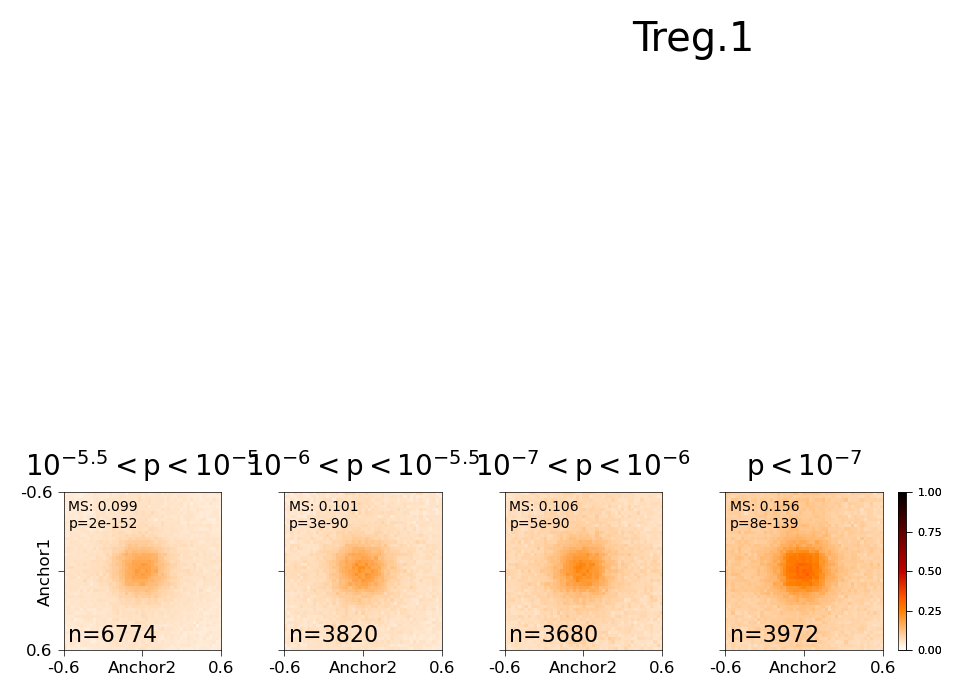

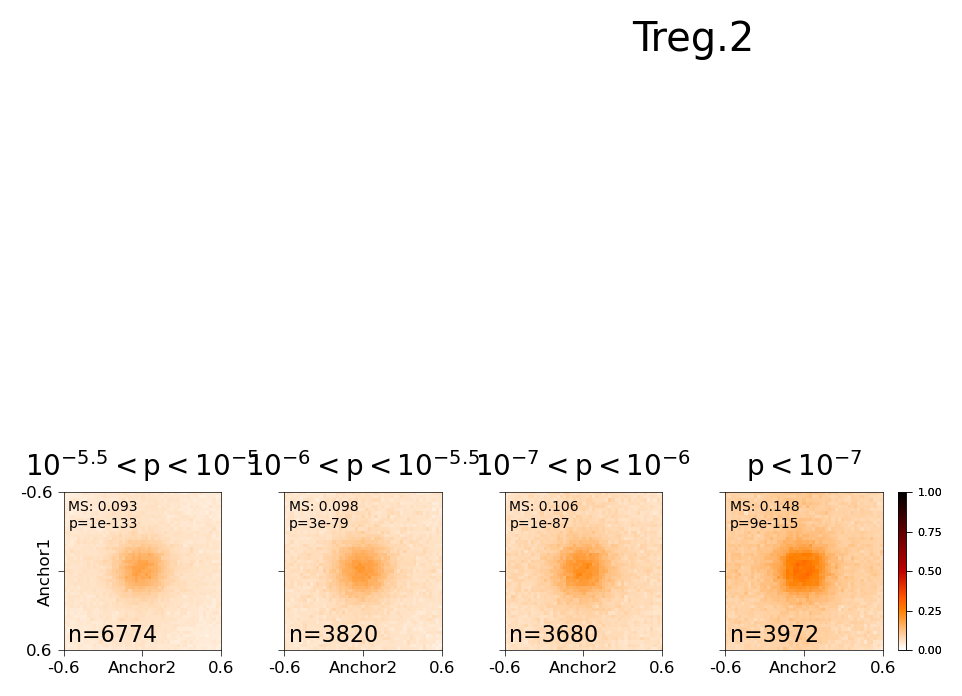

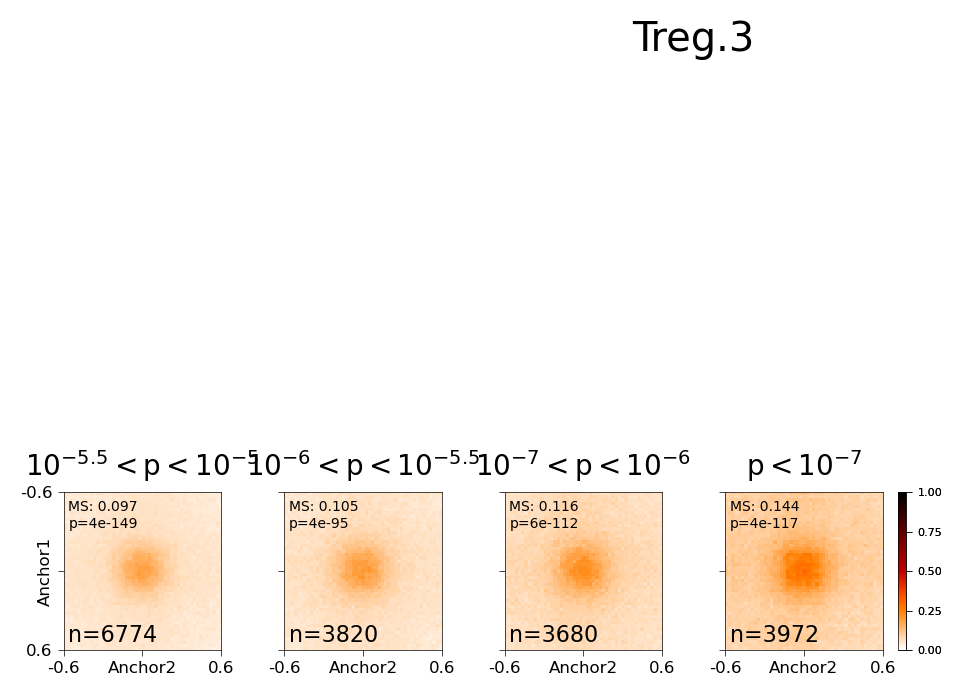

In [26]:
%autoreload 2
from hub_pileup import *

newline = '\n'
all_results_dicts = {}
for key in inter_all_mat_dict:
# for key in ['Treg.1']:
    (fig_within_cluster), results = plot_cluster_pileups_from_result(key, inter_all_mat_dict, inter_all_metadata2,
                                     sorted(inter_all_metadata2['cluster1'].unique()),
                                     res = 25_000,
                                     vmax = 1,
                                     vmin = 0,
                                     columns_to_names = columns_to_names,
                                     row_colors_dict = row_colors_dict,
                                     center = 5, cross_plot = False, 
                                                                     s2 = -1,
                                                                     s1 = 6,
                                                                     xspace=1.4,
                                    )
    fig_within_cluster = fig_within_cluster[0]
    fig_within_cluster.suptitle(f"{key}", y=7.6, x=4, ha='center')
    fig_within_cluster.savefig(f'./plots/paper/s14/{key}_interchromosomal_pileup.pdf', bbox_inches='tight')
    all_results_dicts[key] = results